In [1]:
import tensorflow as tf
import os
import zipfile


DESIRED_ACCURACY = 0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('acc') > 0.999:
      print("\n Reached accuracy of 99.9%. Cancelling Training!")
      self.model.stop_training = True

callbacks = myCallback()

--2019-07-10 12:46:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2019-07-10 12:46:43 (177 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



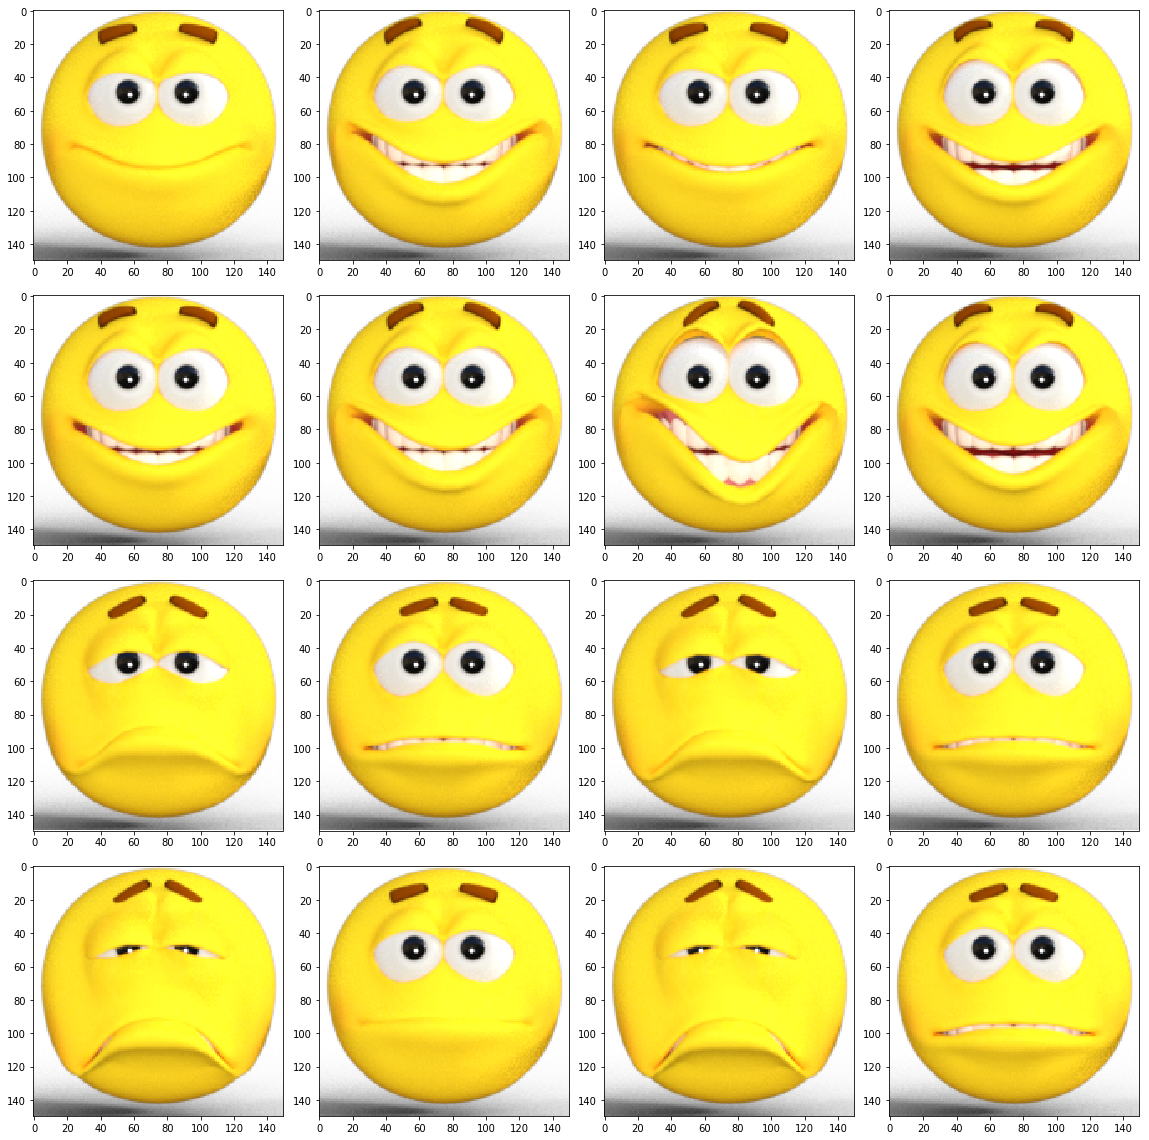

In [2]:
happy_image_dir = os.path.join('/tmp/h-or-s/happy')
happy_image_list=[os.path.join(happy_image_dir, fname) for fname in os.listdir(happy_image_dir)]
sad_image_dir = os.path.join('/tmp/h-or-s/sad')
sad_image_list=[os.path.join(sad_image_dir, fname) for fname in os.listdir(sad_image_dir)]

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(4 * 4, 4 * 4)

for i, img in enumerate(happy_image_list[:8] + sad_image_list[:8]): 
  plt.subplot(4,4,i+1)
  im=mpimg.imread(img)
  plt.imshow(im)
  
plt.tight_layout()  
plt.show()


In [3]:
# This Code Block should Define and Compile the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

from tensorflow.keras.optimizers import RMSprop

model.compile(loss = 'binary_crossentropy',
             optimizer = RMSprop(lr=0.001),
             metrics = ['accuracy'])

model.summary()

W0710 12:48:06.688693 140401327916928 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0710 12:48:06.860228 140401327916928 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9248)              0

In [4]:
# This code block should create an instance of an ImageDataGenerator called train_datagen 
# And a train_generator by calling train_datagen.flow_from_directory

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    '/tmp/h-or-s',
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)
# Expected output: 'Found 80 images belonging to 2 classes'

Found 80 images belonging to 2 classes.


In [5]:
# This code block should call model.fit_generator and train for
# a number of epochs. 
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 4,
    epochs = 20,
    verbose = 1,
    callbacks = [callbacks]
)
    
# Expected output: "Reached 99.9% accuracy so cancelling training!""

Epoch 1/20
4/4 [==============================] - 2s 579ms/step - loss: 0.9718 - acc: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 386ms/step - loss: 0.4701 - acc: 0.8875
Epoch 3/20
4/4 [==============================] - 2s 382ms/step - loss: 0.2783 - acc: 0.9000
Epoch 4/20
4/4 [==============================] - 2s 383ms/step - loss: 0.3770 - acc: 0.8375
Epoch 5/20
4/4 [==============================] - 2s 383ms/step - loss: 0.1337 - acc: 0.9625
Epoch 6/20
3/4 [=====================>........] - ETA: 0s - loss: 0.0665 - acc: 1.0000
 Reached accuracy of 99.9%. Cancelling Training!
4/4 [==============================] - 2s 387ms/step - loss: 0.0522 - acc: 1.0000


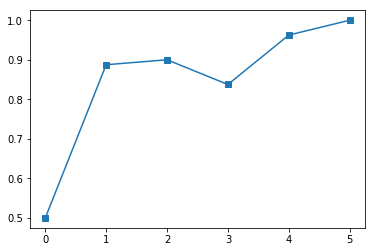

In [6]:
plt.plot(history.epoch, history.history['acc'], marker = 's')